In [48]:
import random
import numpy as np
import math
from scipy.stats import norm
from scipy.stats import beta
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import itertools
%matplotlib inline


def mixed_beta(x):
    if 0 < x < 1:
        return 0.6*beta.pdf(x, 1, 8) + 0.4*beta.pdf(x, 9, 1)
    else:
        return 0.00001


def mcmc_sampling(init, scale=1, t=5000):
    T = t
    theta = [0.0] * (T + 1)
    theta[0] = init
    t = 0
    while t < T:
        t = t + 1
        theta_star = theta[t - 1] + norm.rvs(loc=0, scale=scale, size=1, random_state=None)
        alpha = min(1, (mixed_beta(theta_star[0]) / mixed_beta(theta[t - 1])))
        u = random.uniform(0, 1)
        if u <= alpha:
            theta[t] = theta_star[0]
        else:
            theta[t] = theta[t - 1]
    return theta

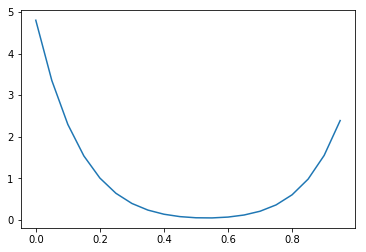

In [5]:
func = np.frompyfunc(mixed_beta, 1, 1)
x = np.arange(0, 1, 0.05)
y = func(x)
plt.plot(x, y)
plt.show()

1. MCMC for Sampling

The random variable X has a mixture distribution: 60% in a Beta(1,8) distribution and 40% in a Beta(9,1) distribution. Therefore, the pdf is as belowed:
\begin{equation}
f(x)= 0.6 * Beta(1, 8) + 0.4 * Beta(9,1)
\end{equation}
i. Implement a Metropolis-Hastings algorithm to generate samples from this distribution.

First of all, we plot the real pdf of mixed beta distribution in order to check the validation of the method we use. 
Metropolis-Hastings algorithm:<br>
When performing Bayesian inference, we aim to compute and use the full posterior joint distribution over a set of random variables. Unfortunately, this often requires calculating intractable integrals. In such cases, we proceed with sampling techniques based upon Markov Chain. The Metropolis-Hastings (MH) algorithm is one of methods, which simulates samples from a probability distribution by making use of the full joint density function and (independent) proposal distributions.
The algorithm is as belowed:

1. Initialize:x^0~q(x)
2. for:i = 1,2,3,...do
3. Propose: $x^{cand}$~$q(x^{i}|x^{i-1})$
4. Acceptance Probability:
5. $\alpha$ = min{1, $\frac{q(x^{i}|x^{cand})\pi^{cand}}{q(x^{cand}|x^{i})\pi^{i-1}}$}
6. u~Uniform (u; 0; 1)
7. if u < $\alpha$ then Accept the proposal: x(i) $\leftarrow$  xcand<br>
   else Reject the proposal: x^(i)  $\leftarrow$  x^(i-1)

In the first experiment, we use norm distribution as our the proposal distribution since the norm distribution is symmetric and radial basis function, $q(x^{i}|x^{i-1})$ = $q(x^{i-1}|x^{i})$, the acceptance rate is also simplified.

In [2]:
def plot_res(theta, T=5000):
    plt.figure(figsize=(16,8)) 
    ax1 = plt.subplot(211)
    ax2 = plt.subplot(212)
    plt.sca(ax1)
    plt.plot(range(T + 1), theta, 'g-')
    plt.sca(ax2)
    num_bins = 50
    plt.hist(theta, num_bins, normed=1, facecolor='red', alpha=0.5)
    plt.show()

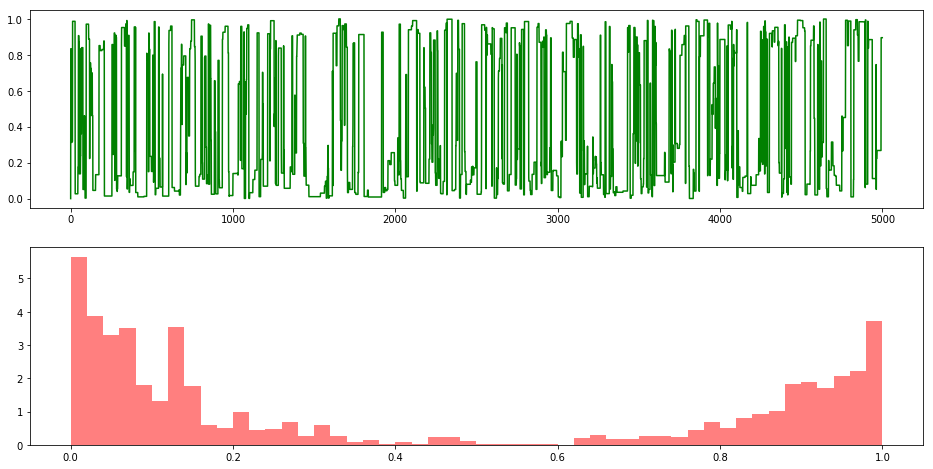

In [14]:
T = 5000
theta = mcmc_sampling(0, scale=1, t=T)
plot_res(theta)

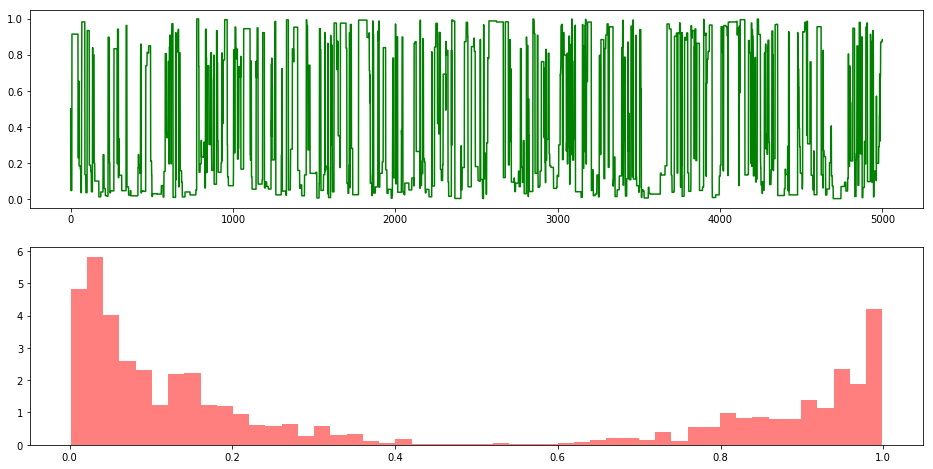

In [15]:
theta = mcmc_sampling(0.5, scale=1, t=T)
plot_res(theta)

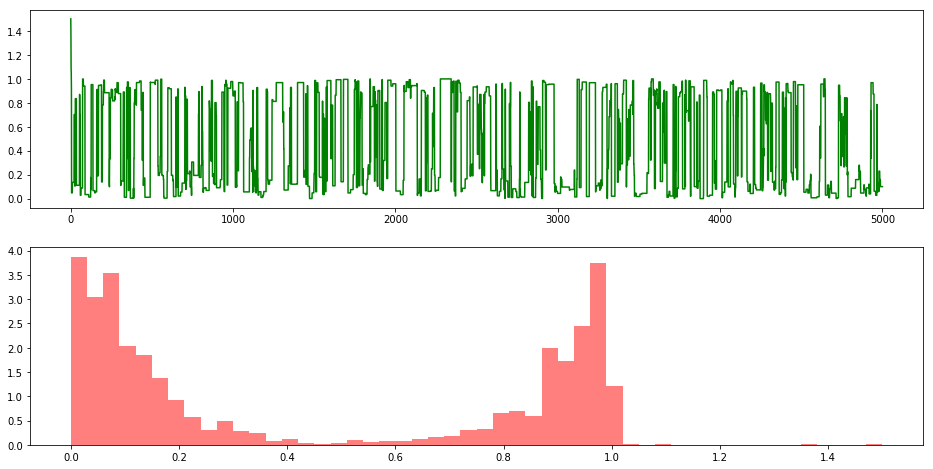

In [24]:
theta = mcmc_sampling(1.5, scale=1, t=T)
plot_res(theta)

In [3]:
def check_answer(res, k=4):
    degree_of_freedom = k - 1
    # The threshold at a 5% significance level of different degree_of_freedom
    chi_squared_dict = {
        1: 3.84,
        2: 5.99,
        3: 7.82,
        4: 9.49,
        5: 11.07,
        6: 12.59,
        7: 14.07,
        8: 15.51,
        9: 16.92,
        10: 18.31,
    }
    if res <= chi_squared_dict[degree_of_freedom]:
        probability_of_truth = 0.95
    else:
        probability_of_truth = 0.05
    return probability_of_truth


def chi_squard(expected, estimated):
    tmp = np.power(expected - estimated, 2)
    res = tmp / expected 
    return np.sum(res) * 5000
    
def estimate_convergence_time(theta, expected, strata=10):
    theta = np.array(theta)
    prob = 0
    start = np.where(theta < 1)[0][0]
    count = int(start/10) + 1
    while prob != 0.95 and count <= 500:
        count += 1
        p, t = np.histogram(theta[start:count*10], bins=4, range=(0, 1))
        p = p/(count * 10)
        print(p)
        chi_value = chi_squard(expected, p)
        prob = check_answer(chi_value)
    if count <= 500:
        return count
    else:
        return -1

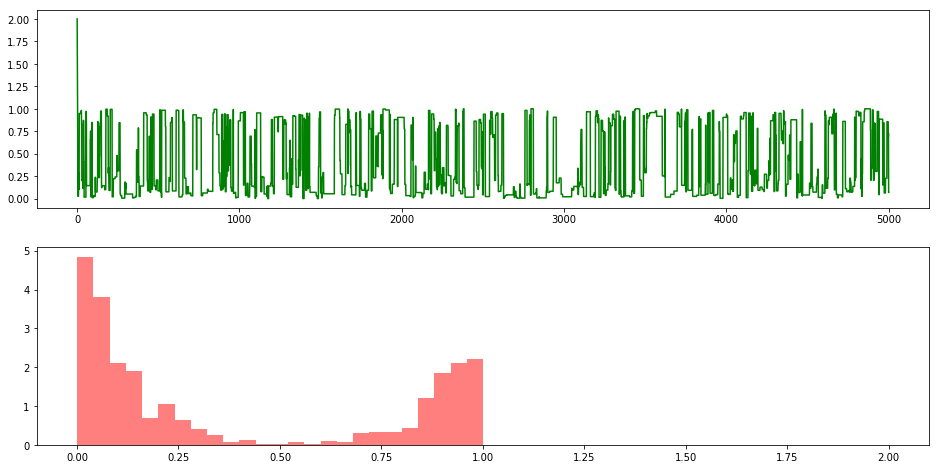

In [22]:
from scipy import integrate
expected = []
for i in range(0, 4):
    area, err = integrate.quad(mixed_beta, 0.25 * i, 0.25 * (i+1))
    expected.append(area)

theta = mcmc_sampling(2.0)
plot_res(theta)

ii. Run the algorithm multiple times from different initial points. Plot sample paths for the algorithm. Can you tell if/when the algorithm converges to its equilibrium distribution?

We use different initial points to run the algorithm multiple times and plots their sample path. Apparently，we know that all the sample path will be limited in the range [0, 1] and repeat some pattern during some period， which means that the the algorithm converges to its equilibrium distribution. Of course the algorithm will convergence， That's because it satisfy the detailed balance condition
$$\pi(i)P_{ij} = \pi(j)P_{ji}$$
Proof:

\begin{align}
\pi(x)q(x^{*}|x)\alpha(x^{*}) &= \pi(x) * q(x^{*}|x) * min(1, \frac{\pi(x^*)q(x|x^{*})}{\pi(x)q(x^{*}|x)})\\
&= min(\pi(x) * q(x^{*}|x), \pi(x^*)q(x|x^{*}))\\
&= \pi(x^*) * q(x|x^*) * min(1, \frac{\pi(x)q(x^*|x)}{\pi(x^*)q(x|x^*)})\\
&= \pi(x^*)q(x|x^*)\alpha(x)
\end{align}
Given the equation, we could get that 
\begin{equation}
\sum_{i=1}^{\infty}\pi(i)P_{ij} = \sum_{i=1}^{\infty}\pi(j)P_{ji} = \pi(j)\\
\Rightarrow \pi P = \pi
\end{equation}
And we get the initial points will have effect on the convergence. The closer the initial point to the range， the faster the convergence is.
Once the point get into the range, the probability that it escape out of the range will be small enough.

In [51]:
from scipy import integrate

expected = []
for i in range(0, 4):
    area, err = integrate.quad(mixed_beta, 0.25 * i, 0.25 * (i+1))
    expected.append(area)

print("expected:", expected)

expected: [0.5399337768554686, 0.05850372314453124, 0.031587219238281256, 0.3699752807617188]


In [50]:
def estimate_convergence_time(theta, expected, strata=10):
    theta = np.array(theta)
    prob = 0
    start = np.where(theta < 1)[0][0]
    count = int(start/10) + 1
    while prob != 0.95 and count <= 500:
        count += 1
        p, t = np.histogram(theta[start:count*10], bins=4, range=(0, 1))
        p = p/(count * 10)
        chi_value = chi_squard(expected, p)
        prob = check_answer(chi_value)
    if count <= 500:
        return count
    else:
        return -1

In [58]:
theta = mcmc_sampling(0)
count = estimate_convergence_time(theta, expected)
print("The convergence time might be", count)

The convergence time might be 164


Let us try to estimate the convergence time. I just use chi_squard goodness of fit to estimate whether it could convergence. Since the sample path will repeat some pattern in order to keep the its equilibrium distribution. At some point, its chi-squard must satisfy our hypothesis. Luckily, it works. Howerver, the convergence time is round, not exact and I think the value I get must be larger than the atucal value.

In [4]:
def calculate_chi(theta):
    p, t = np.histogram(theta, bins=4, range=(0, 1))
    p = p/5000
    chi_value = chi_squard(expected, p)
    return chi_value

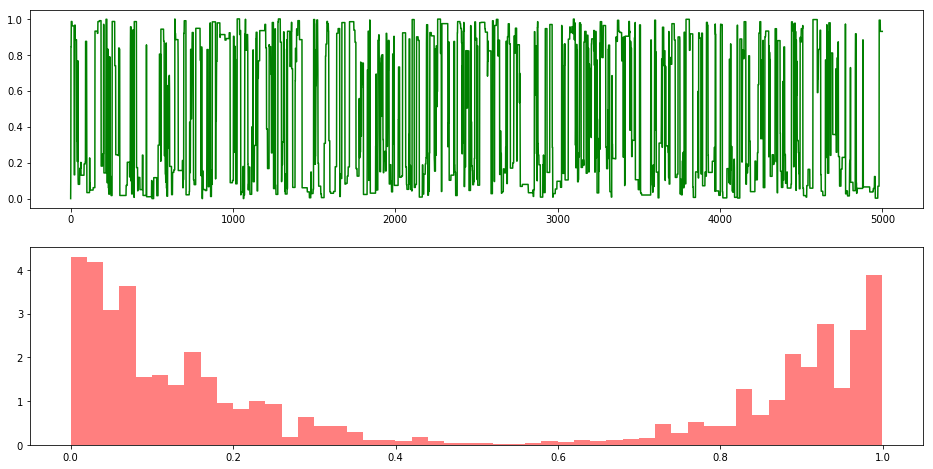

chi_squard value is 1.3581148168815622


In [101]:
theta = mcmc_sampling(0, 0.8)
plot_res(theta)
print("chi_squard value is", calculate_chi(theta))

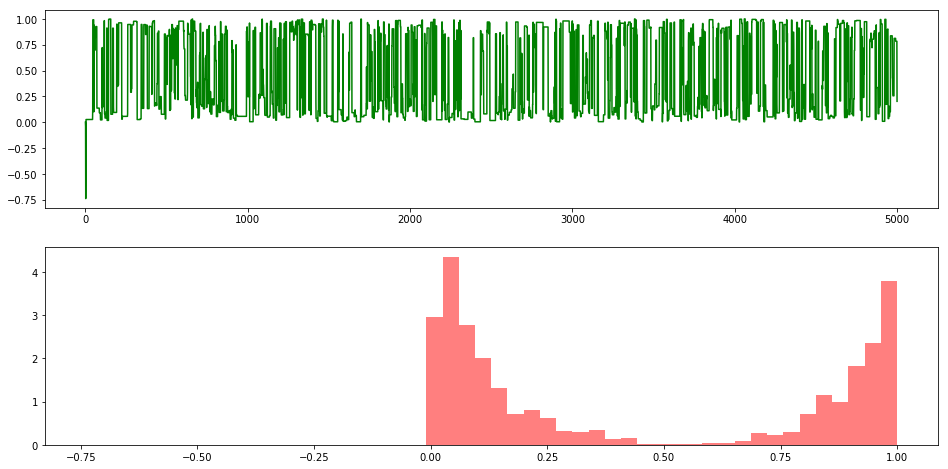

chi_squard value is 13.538910130201213


In [82]:
def mcmc_sampling_uniform(init, t=5000):
    T = t
    theta = [0.0] * (T + 1)
    theta[0] = init
    t = 0
    while t < T:
        t = t + 1
        theta_star = theta[t - 1] + random.uniform(-1, 1)
        alpha = min(1, (mixed_beta(theta_star) / mixed_beta(theta[t - 1])))
        u = random.uniform(0, 1)
        if u <= alpha:
            theta[t] = theta_star
        else:
            theta[t] = theta[t - 1]
    return theta


theta = mcmc_sampling_uniform(0)
plot_res(theta)
print("chi_squard value is", calculate_chi(theta))

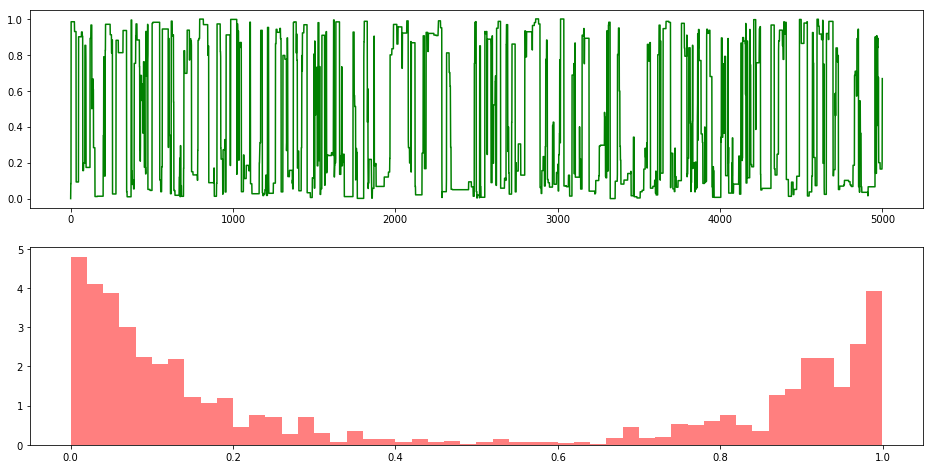

chi_squard value is 2.5103581235141674


In [79]:
from scipy.stats import cauchy

def mcmc_sampling_cauchy(init, t=5000):
    T = t
    theta = [0.0] * (T + 1)
    theta[0] = init
    t = 0
    while t < T:
        t = t + 1
        theta_star = theta[t - 1] + cauchy.rvs(0, 0.75)
        alpha = min(1, (mixed_beta(theta_star) / mixed_beta(theta[t - 1])))
        u = random.uniform(0, 1)
        if u <= alpha:
            theta[t] = theta_star
        else:
            theta[t] = theta[t - 1]
    return theta


theta = mcmc_sampling_cauchy(0)
plot_res(theta)
print("chi_squard value is", calculate_chi(theta))

Plot sample paths for the algorithm using different proposal pdfs.
There are mainly two kinds of proposal distributions, symmetric and asymmetric. Straightforward choices of symmetric proposals include Gaussian distributions, Cauchy Distuibution, laplace distribution or Uniform distributions centered at the current state of the chain. However, all the performance of the proposal distribution depends on the actual situation and we need to set suitable parameter to make the algorithm better. And We prefer symmetric to asymmetric distribution because it is simpler. Only if we confront the skew problem， we might use asymmetric distribution. Here， I use Cauchy distribution， norm distribution and uniform and I try my best to set proper parameter. 

From the plot and chi-squard value of each distribution, we could conclude that the uniform performs worst and Cauchy perform better. Because the center is tine.

In [57]:
chi = []
for i in range(0, 50):
    theta = mcmc_sampling(0.5, scale=1)
    chi.append(calculate_chi(theta))
    
print("chi_squard value is", np.mean(chi))

chi_squard value is 33.16605104436671


In [102]:
chi = []
for i in range(0, 50):
    theta = mcmc_sampling(0.5, scale=2)
    chi.append(calculate_chi(theta))
    
print("chi_squard value is", np.mean(chi))

chi_squard value is 54.0845744802735


In [104]:
chi = []
for i in range(0, 50):
    theta = mcmc_sampling(0.5, scale=5)
    chi.append(calculate_chi(theta))
    
print("chi_squard value is", np.mean(chi))

chi_squard value is 148.64088727187476


In [103]:
chi = []
for i in range(0, 50):
    theta = mcmc_sampling(0.5, scale=0.8)
    chi.append(calculate_chi(theta))
    
print("chi_squard value is", np.mean(chi))

chi_squard value is 28.09487840050463


In [105]:
chi = []
for i in range(0, 50):
    theta = mcmc_sampling(0.5, scale=0.5)
    chi.append(calculate_chi(theta))
    
print("chi_squard value is", np.mean(chi))

chi_squard value is 27.382092515588408


In [106]:
chi = []
for i in range(0, 50):
    theta = mcmc_sampling(0.5, scale=0.2)
    chi.append(calculate_chi(theta))
    
print("chi_squard value is", np.mean(chi))

chi_squard value is 183.28602139556742


Comment on the effect of low-variance vs high-variance proposal pdfs on the behavior of your algorithm.

As for the effect of variance of proposal pdfs，we also should set proper variance since decrease variance means smaller step and lower acceptance. By contrast increase variance means larger step and higher acceptance. From chi-squard value，we could see the chi-squard value decreases firstly and then increase as the variance increases.

In [107]:
def scwefel_2d(x1, x2):
    return 2 * 418.9829 - (x1 * math.sin(math.pow(abs(x1), 0.5))
                           + x2 * math.sin(math.pow(abs(x2), 0.5)))


func2 = np.frompyfunc(scwefel_2d, 2, 1)


def plot_obj_func():
    x = np.arange(-500.0, 500.0, 0.5)
    y = np.arange(-500.0, 500.0, 0.5)
    X, Y = np.meshgrid(x, y)
    Z = func2(X, Y)
    plt.figure(figsize=(10, 6))
    cset = plt.contourf(X, Y, Z, cmap=plt.cm.hot)
    contour = plt.contour(X, Y, Z)
    plt.clabel(contour, fontsize=10, colors='k')
    plt.colorbar(cset)
    plt.show()

    fig = plt.figure()
    ax = Axes3D(fig)
    ax.plot_surface(X, Y, Z)
    plt.show()
    return 0



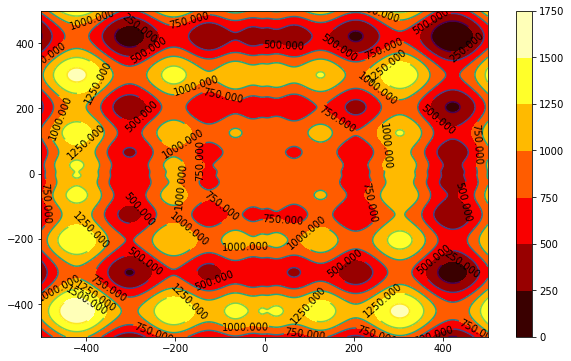

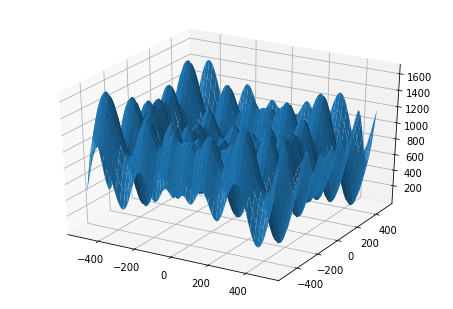

0

In [108]:
plot_obj_func()

MCMC for Optimization
The n-dimensional Scwefel function is a very bumpy surface with many local critical points and one global minimum. We will explore the surface for the case n=2 dimensions.
i. Plot a contour plot of the surface for the 2-D surface
I plot its 3-d picture and a coutour of the surface. From the figure above，it's very bumpy, which means there are so mant local minmum. We should set a enough step to jump out of the local minmum. And we can easily see the minimum field it might be from the first picture. I estimates that the minmum points might be right corner.

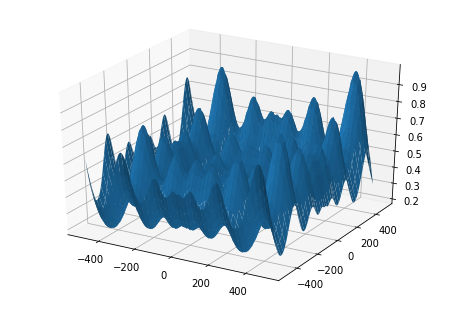

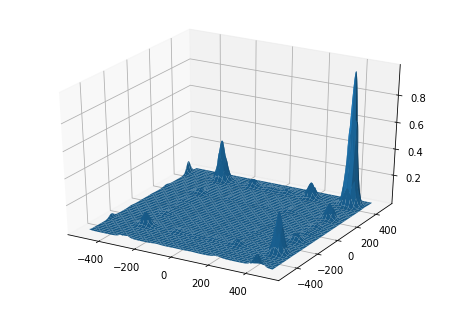

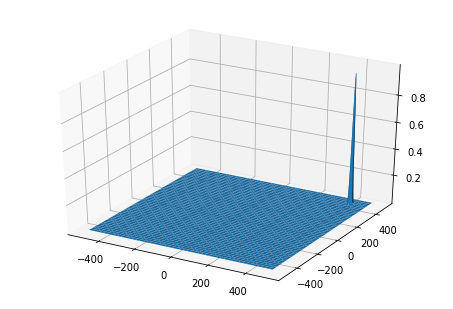

In [74]:
def convert_func(x, T):
    return math.exp(-(x/T))


func3 = np.frompyfunc(convert_func, 2, 1)


def plot_obj_convert(T):
    x = np.arange(-500.0, 500.0, 0.5)
    y = np.arange(-500.0, 500.0, 0.5)
    X, Y = np.meshgrid(x, y)
    Z = func2(X, Y)
    Z_1 = func3(Z, T)
 
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.plot_surface(X, Y, Z_1)
    plt.show()


plot_obj_convert(1000)
plot_obj_convert(100)
plot_obj_convert(10)

ii. Implement a simulated annealing procedure to find the global minimum of this surface

Simulated annealing (SA) is a probabilistic technique for approximating the global optimum of a given function, which is base on MCMC and use Metropolis-Hastings algorithm to construct MC chain. Each step is a MC chain. Actually, it's a combination of many MC chains.

convertion fucntion<br>
SA use the convertion fucntion as the Q fucntion we refered to before. From the picture, we can see that when T is large, the surface is bumpy and as the T become small, the surface become smooth and only one mountain left. Fortunately, it's our expectation point.

SA procedure:<br>
It starts from a state s0 and continues until a maximum of kmax steps have been taken. In the process, the call neighbour(s) should generate a randomly chosen neighbour of a given state s; the call random(0, 1) should pick and return a value in the range [0, 1], uniformly at random. The annealing schedule is defined by the call temperature(r), which should yield the temperature to use, given the fraction r of the time budget that has been expended so far.

In [112]:
def simulated_annealing(t=50, alpha_func='constant'):
    T_init = 1000  
    T_min = 1e-20 
    T = T_init
    x = random.uniform(-1, 1) * 500
    y = random.uniform(-1, 1) * 500
    
    z = scwefel_2d(x, y)

    x_best = x
    y_best = y
    z_best = z
    
    cycle = 1
    if alpha_func == 'exponential':
        alpha = lambda cycle: math.pow(0.85, cycle)
    elif alpha_func == 'polynomial':
        alpha = lambda cycle: 1/(1 + 0.5 * math.pow(cycle, 2))
    elif alpha_func == 'logarithmic':
        alpha = lambda cycle: 1/(1 + 1.5 * math.log(1 + cycle))
    else:
        alpha = lambda cycle: 0.995 

    results = []
    while T > T_min:
        for i in range(t):
            delta_x = norm.rvs(loc=0, scale=1, size=1, random_state=None)*50
            delta_y = norm.rvs(loc=0, scale=1, size=1, random_state=None)*50


            if -500 < (x + delta_x) < 500:
                x_new = x + delta_x
            else:
                x_new = x - delta_x

            if -500 < (y + delta_y) < 500:
                y_new = y + delta_y
            else:
                y_new = y - delta_y

            z_new = scwefel_2d(x_new, y_new)

            if z_new < z or math.exp(-(z_new - z) / T) >= random.random():
                x = x_new
                y = y_new
                z = z_new
                if z < z_best:
                    x_best = x
                    y_best = y
                    z_best = z

        results.append((x_best, y_best, z_best))
        T *= alpha(cycle)
        cycle += 1

#     print('best solution x:%f,y:%f,z:%f' % results[-1])

    # plot_iter_curve(results)

    return results

In [99]:
res = simulated_annealing(t=500)

best solution x:420.924535,y:420.945313,z:0.000341


ii. Implement a simulated annealing procedure to find the global minimum of this surface

I set the parameter to make the algorithm very slow so that it could get the best solution. I set the initial temperature as 1000 and use constant number 0.995 to play the role of cooling schedule and 500 as the iteration. In this case, the algorithm could converge at any temperature and finally it could converge to the minimum. The minimum is 0.000341 and its corresponding point is (420.924535, 420.945313). But it's really slow. Next, I change the cooling schedule and change parameters to fasten the algorithm.

In [110]:
def repeat_sa(t, repeat, cooling):
    final_result = np.zeros((repeat, 3))
    for k in range(0, repeat):
        tmp, cycle = simulated_annealing(t=t, alpha_func=cooling)[-1]
        final_result[k][0] = tmp[0]
        final_result[k][1] = tmp[1]
        final_result[k][2] = tmp[2]
    res = final_result.min(axis=0)[2]
    index = np.where(final_result == res)
    fres = final_result[index[0]][0]
    print('best solution x:%f,y:%f,z:%f' % (fres[0], fres[1], fres[2]))
    return final_result

In [132]:
def hist_res(res):
    plt.figure(figsize=(16,8))
    num_bins = 50
    plt.hist(res, num_bins, normed=1, facecolor='red', alpha=0.5)
    plt.show()

In [137]:
def test_iteration_cooling(cooling):
    res1_20 = repeat_sa(t=20, repeat=100, cooling=cooling)[:,2]
    hist_res(res1_20)
    res1_50 = repeat_sa(t=50, repeat=100, cooling=cooling)[:,2]
    hist_res(res1_50)
    res1_100 = repeat_sa(t=100, repeat=100, cooling=cooling)[:,2]
    hist_res(res1_100)
    res1_1000 = repeat_sa(t=1000, repeat=100, cooling=cooling)[:,2]
    hist_res(res1_1000)

best solution x:420.051336,y:422.634470,z:0.456474


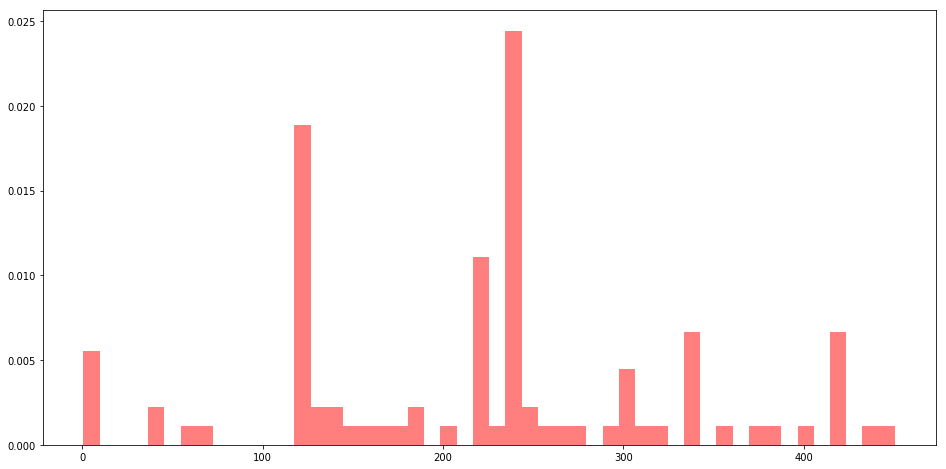

best solution x:421.230570,y:421.941473,z:0.128110


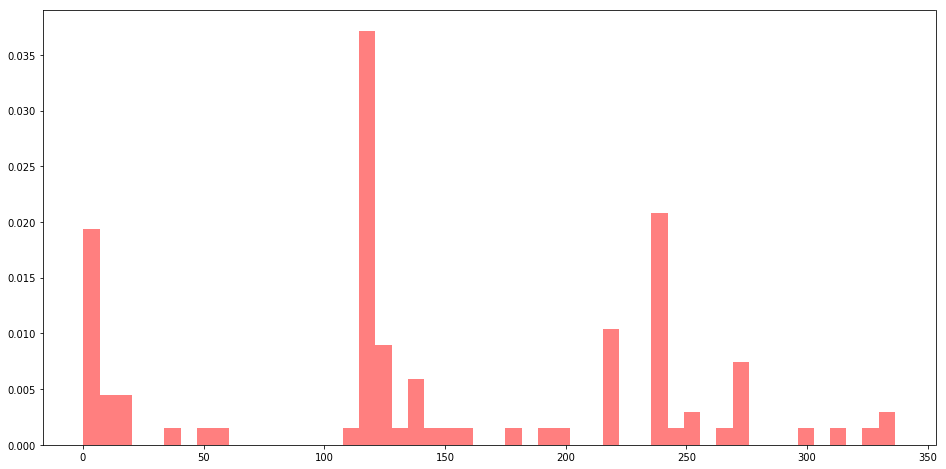

best solution x:420.541827,y:421.544427,z:0.064847


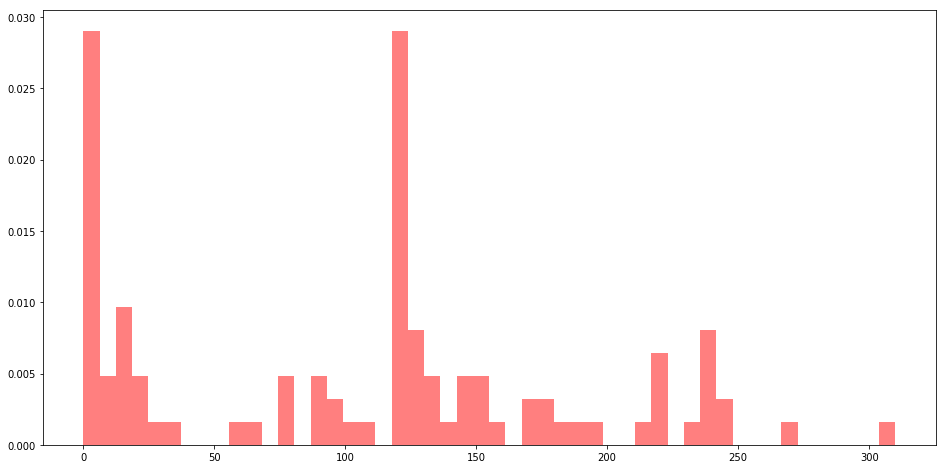

best solution x:420.955787,y:421.053282,z:0.000948


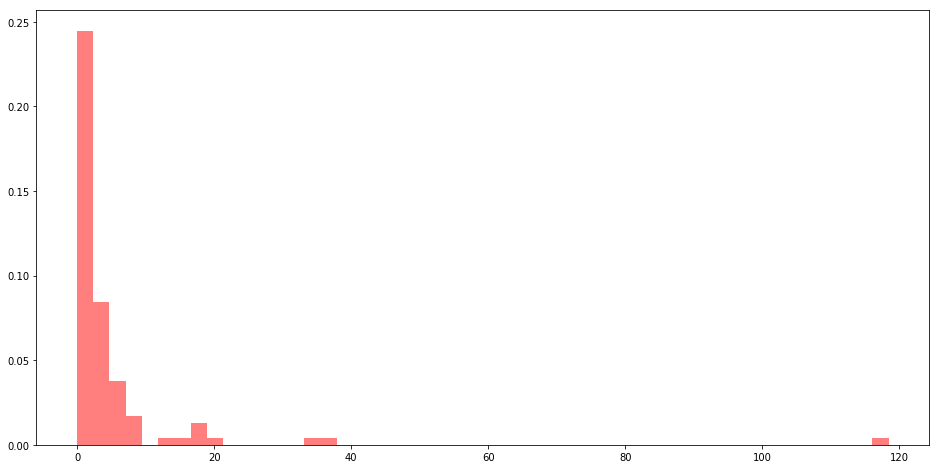

In [138]:
test_iteration_cooling(cooling= 'exponential')

best solution x:422.355997,y:419.238381,z:0.620473


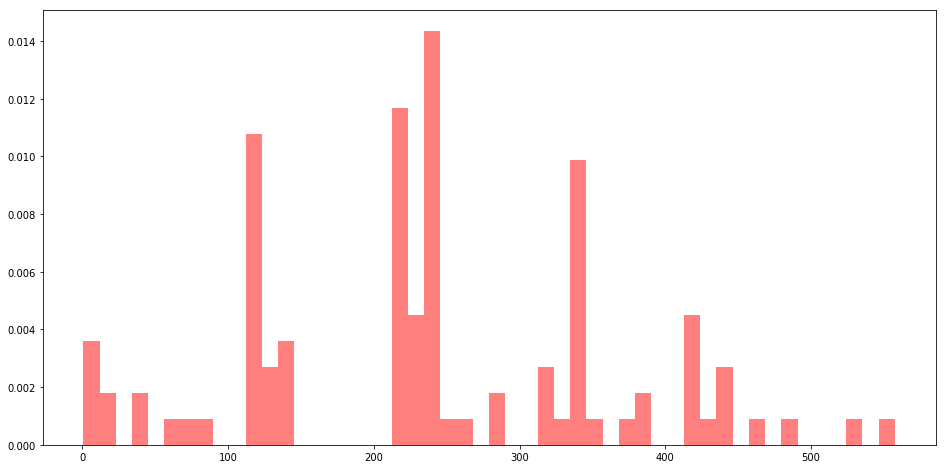

best solution x:421.707366,y:421.608960,z:0.120615


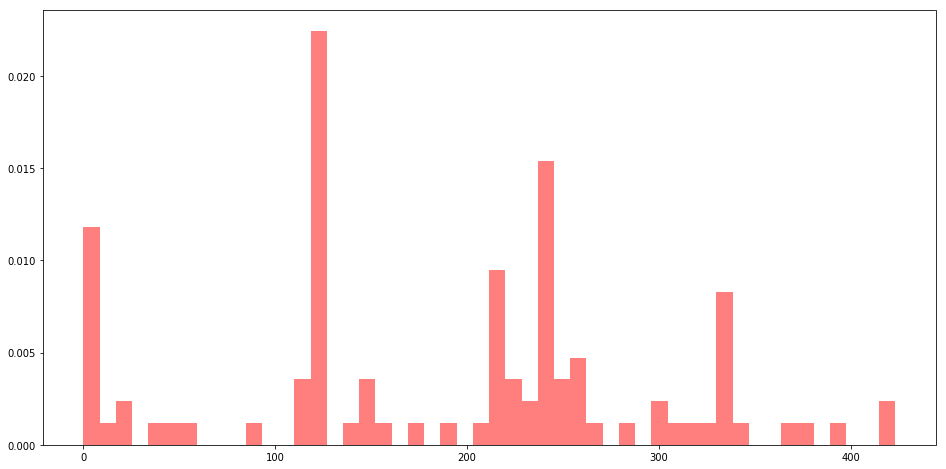

best solution x:421.084613,y:421.771396,z:0.083035


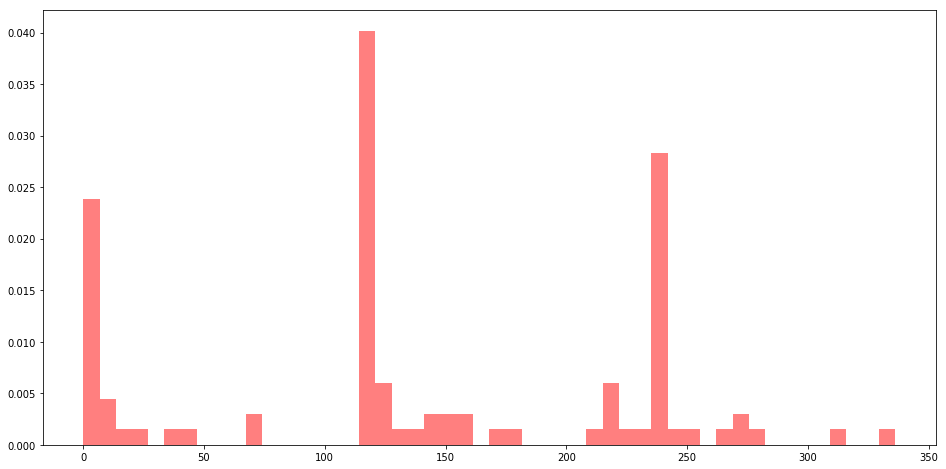

best solution x:420.984419,y:421.041751,z:0.000729


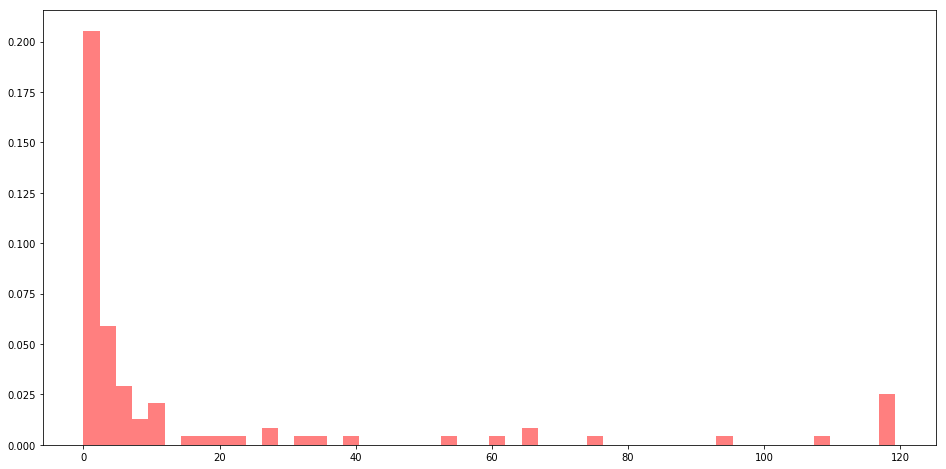

In [139]:
test_iteration_cooling(cooling= 'polynomial')
# res3 = simulated_annealing(t=1000, alpha_func='logarithmic')

best solution x:421.922670,y:420.520605,z:0.140223


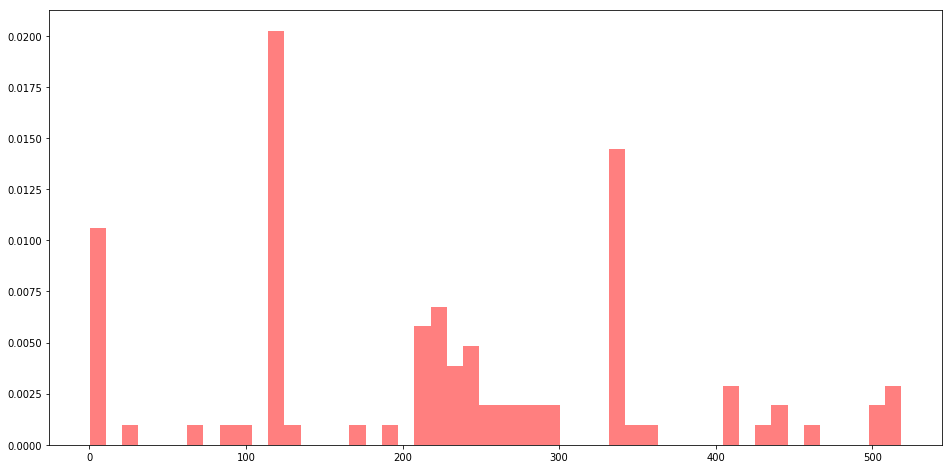

best solution x:420.972749,y:420.839058,z:0.002150


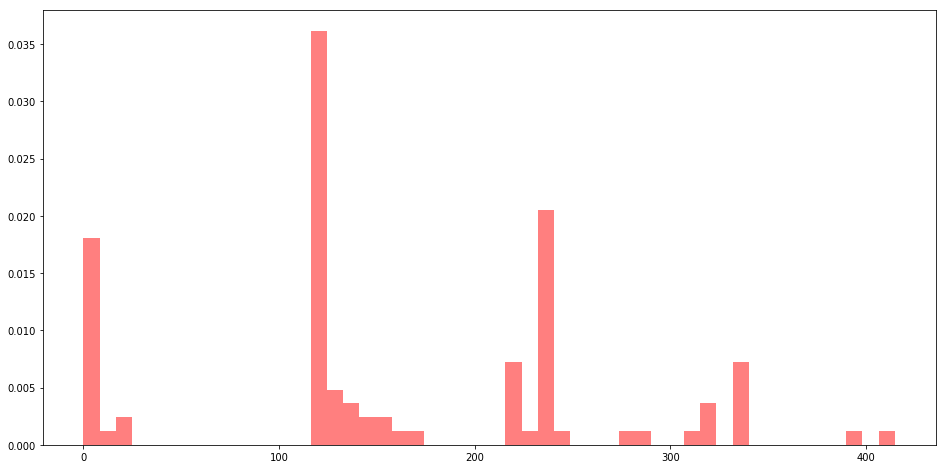

best solution x:420.412091,y:421.127582,z:0.042300


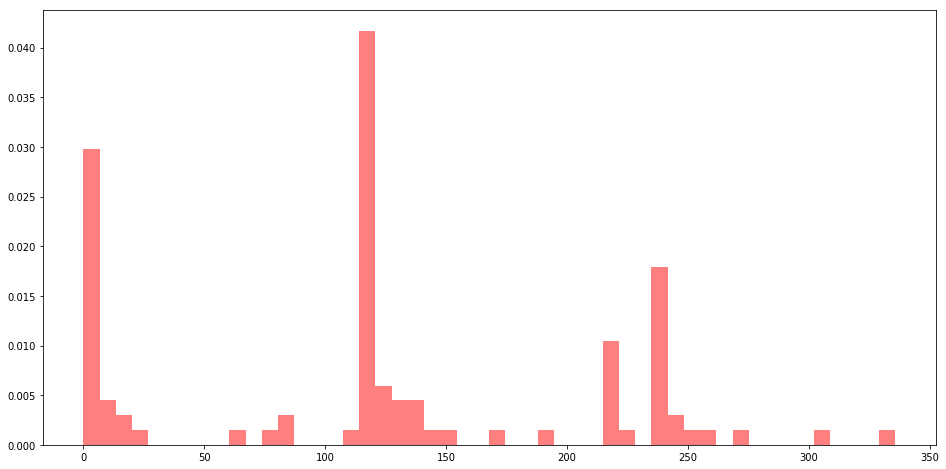

best solution x:420.927055,y:420.969991,z:0.000245


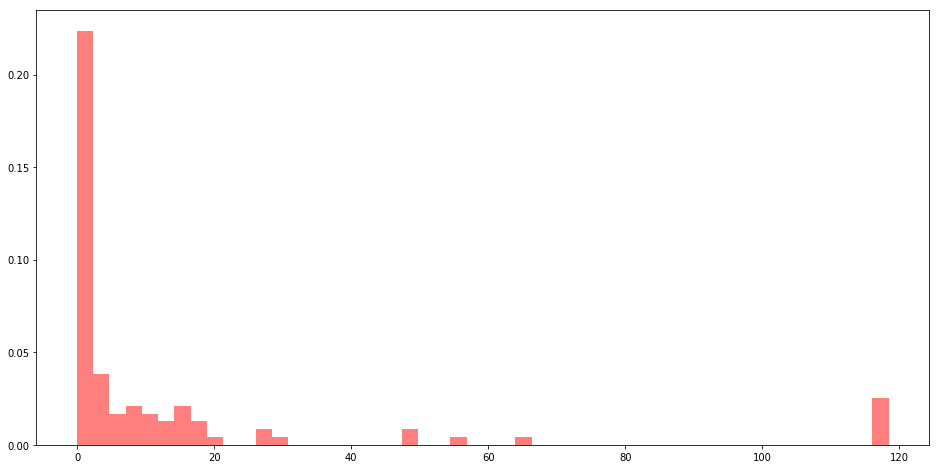

In [140]:
test_iteration_cooling(cooling= 'logarithmic')

iii. Explore the behavior of the procedure starting from the origin with an exponential, a polynomial, and a logarithmic cooling schedule. Run the procedure for t={20, 50, 100, 1000} iterations for k=100 runs each. Plot a histogram of the function minima your procedure converges to.

From the picture, we can conclude that as T increases, the number of convergeing into 0 increases. However, there still are some error answers. From the result，the exponential cooling schedule performs better. And compared to constant cooling schedule，convergence time decreases a lot.

In [111]:
def plot_iter_curve(results):
    X, Y, Z = [], [], []
    for item in results:
        X.append(item[0])
        Y.append(item[1])
        Z.append(item[2])

    fig = plt.figure(1)
    ax = fig.gca(projection='3d')

    figure = ax.plot(X, Y, Z, c='r')
    plt.show()

iv. Choose your best run and overlay your 2-D sample path on the contour plot of the Schwefel function to visualize
the locations your optimization routine explored.

best solution x:420.848477,y:421.740665,z:0.077058


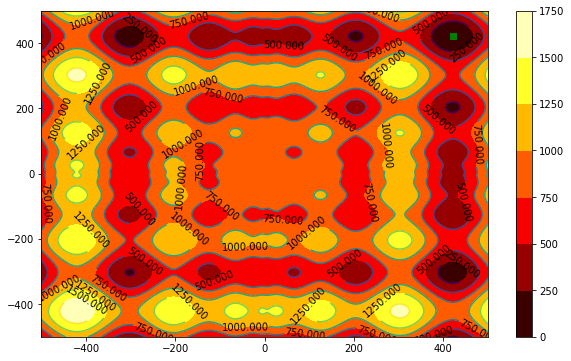

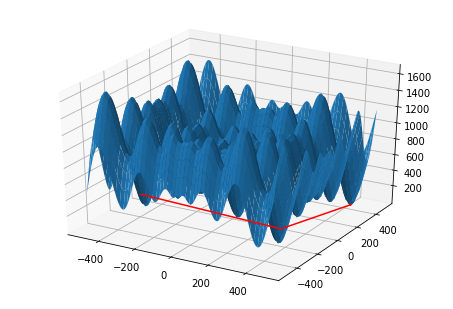

In [126]:
minimum = float('inf')

for k in range(0, 10):
    tmp = simulated_annealing(t=100, alpha_func='exponential')
    tmp1 = tmp[-1]
    if tmp1[2] < minimum:
        minimum = tmp1[2]
        final_res = tmp

fres = final_res[-1]
print('best solution x:%f,y:%f,z:%f' % (fres[0], fres[1], fres[2]))

x = np.arange(-500.0, 500.0, 0.5)
y = np.arange(-500.0, 500.0, 0.5)
X, Y = np.meshgrid(x, y)
Z = func2(X, Y)

plt.figure(figsize=(10, 6))
cset = plt.contourf(X, Y, Z, cmap=plt.cm.hot)
contour = plt.contour(X, Y, Z)
plt.clabel(contour, fontsize=10, colors='k')
plt.colorbar(cset)
plt.plot(fres[0], fres[0],'gs')
plt.show()


X1, Y1, Z1 = [], [], []
for item in final_res:
    X1.append(item[0][0])
    Y1.append(item[1][0])
    Z1.append(item[2][0])

fig = plt.figure()
ax = Axes3D(fig)
ax.plot_surface(X, Y, Z)
ax.plot(X1, Y1, Z1, c='r')
plt.show()


In [5]:
def pick_cities(n):
    cities = []
    for i in range(0, n):
        x = random.randint(0, 1000)
        y = random.randint(0, 1000)
        cities.append([x, y])
    return cities


def getdistmat(init_cities):
    n = len(init_cities)
    distmat = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):
            distmat[i][j] = distmat[j][i] = np.linalg.norm(init_cities[i]-init_cities[j])
    return distmat


def calculate_distance(cities, distance_mat):
    distance = 0
    n = len(cities)
    for i in range(0, n - 1):
        distance += distance_mat[cities[i]][cities[i+1]]
    return distance


# def generate_new_path(cities):
#     n = len(cities)
#     i = random.randint(0, n-1)
#     j = random.randint(0, n-1)
#     while j == i:
#         j = random.randint(0, n-1)   # randint包含边界
#     cities[i], cities[j] = cities[j], cities[i]
#     return cities


def generate_new_path(cities):
    n = len(cities)
    i = random.randint(0, n-1)
    j = random.randint(0, n-1)
    while j == i:
        j = random.randint(0, n-1)   # randint包含边界

    u = random.random()
    if u < 0.5:
        cities[i], cities[j] = cities[j], cities[i]
    else:
        change_head = np.min((i, j))
        change_tail = np.max((i, j))
        change_list = cities[change_head:change_tail + 1]
        change_list.reverse()
        cities = cities[:change_head] + change_list + cities[change_tail + 1:]
    return cities


def violence(n, distance_mat):
    solution = [i for i in range(0, n)]
    nums = itertools.permutations(solution, n)
    best_sol = float('inf')
    for x in nums:
        sol = calculate_distance(x, distance_mat)
        best_sol = np.min([sol, best_sol])
    return best_sol


Optimal Paths
The famous Traveling Salesman Problem (TSP) is an NP-hard routing problem.

Firstly, I random choose N cities and then I shuffle the list to set a start point and initiate the parameters. Secondly, I use two ways to generate the new path, the first one is to choose two number randomly and swap them, the second one is to reverse the path between two numeber we choose. Finally, I update your annealing temperature and repeat the previous city swap step. Run the simulated annealing procedure “to convergence.

In [26]:
def init_(n):
    init_cities = pick_cities(n)
    init_cities = np.array(init_cities)
    distance_mat = getdistmat(init_cities)
    return init_cities, distance_mat


def simulated_annealing_tsp(n, init_cities, distance_mat):
    T_init = 4000 
    T_min = 1e-20  
    T = T_init
    
    cycle = 1
    alpha = lambda cycle: math.pow(0.85, cycle)
    
#     alpha = 0.995 

    solution = [i for i in range(0, n)]
    
    random.shuffle(solution)
    distance = calculate_distance(solution, distance_mat)
    
    distance_all = []
    distance_best = distance
    solution_best = solution.copy()

    result = []
    while T > T_min:
        for i in range(1000):
            solution_new = generate_new_path(solution)
            distance_new = calculate_distance(solution_new, distance_mat)

            if distance_new < distance:
                distance = distance_new
                solution = solution_new.copy()

                if distance_new < distance_best:
                    distance_best = distance_new
                    solution_best = solution_new.copy()
            else:
                p = np.min([1, math.exp(-(distance_new - distance))])
                u = random.random()
                if u <= p:
                    distance = distance_new
                    solution = solution_new.copy()
                    
            distance_all.append(distance)
        result.append([distance_best, solution_best])
        
        T *= alpha(cycle)
        cycle += 1
#     print('the closet path is', result[-1])
    return result, distance_all

In [41]:
def repeat_TSP(repeat, n, init_cities, distance_mat):
    minimum = float('inf')
    for k in range(0, repeat):
        tmp, distance_all = simulated_annealing_tsp(n, init_cities, distance_mat)
        if tmp[-1][0] < minimum:
            minimum = tmp[-1][0]
            final_result = tmp[-1][1]
    
    
    return minimum, final_result

In [191]:
import time
init_cities, distance_mat = init_(8)
start = time.time()
vol_sol = violence(8, distance_mat)
end = time.time()
print("8 cities violence runtime:", end-start)

init_cities, distance_mat = init_(9)
start = time.time()
vol_sol = violence(9, distance_mat)
end = time.time()
print("9 cities violence runtime:", end-start)

init_cities, distance_mat = init_(10)
start = time.time()
vol_sol = violence(10, distance_mat)
end = time.time()
print("10 cities violence runtime:", end-start)

8 cities violence runtime: 0.397491455078125
9 cities violence runtime: 3.5437560081481934
10 cities violence runtime: 35.5460524559021


I enumerate all possible the results and choose the minimum to verify my procedure. And I count the time of violence enumerate, which increases exponentially. My computer just could calulate n=20 and if n is larger than 20, my pc is down. So it's a advantage of MCMC solutions .

In [40]:
import time
init_cities, distance_mat = init_(8)
vol_sol = violence(8, distance_mat)
minimum, final_result = repeat_TSP(5, 8, init_cities, distance_mat)
print('The shortest distance is:%f' % minimum, "The best solution is",final_result)

The shortest distance is:1475.626464 The best solution is [1, 6, 0, 2, 4, 5, 7, 3]
The shortest distance is:1475.626464 The best solution is [1, 6, 0, 2, 4, 5, 7, 3]


In [30]:
def plot_path(best_path_list, cities, distance_all):
    x = []
    y = []
    best_path_tmp = [item[0] for item in best_path_list]
    for point in best_path_list[-1][1]:
        x.append(cities[point][0])
        y.append(cities[point][1])
        
    plt.figure(figsize=(16,8)) 
    plt.subplot(311)
    plt.plot(best_path_tmp)
    
    plt.subplot(312)
    plt.plot(distance_all) 
    
    plt.subplot(313)
    plt.scatter(x, y)
    plt.plot(x, y)  
    plt.grid()
    plt.show()


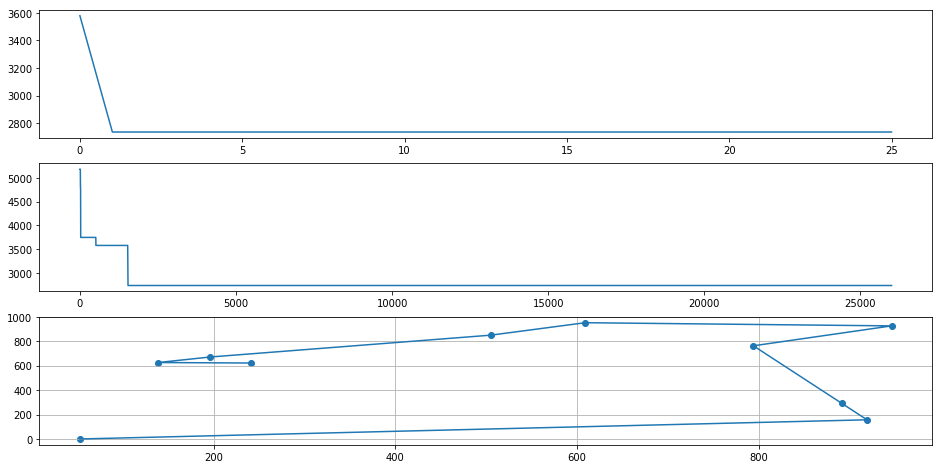

In [33]:
init_cities, distance_mat = init_(10)
res, distance_all = simulated_annealing_tsp(10, init_cities, distance_mat)
plot_path(res, init_cities, distance_all)


TSP run time is 0.9235572814941406


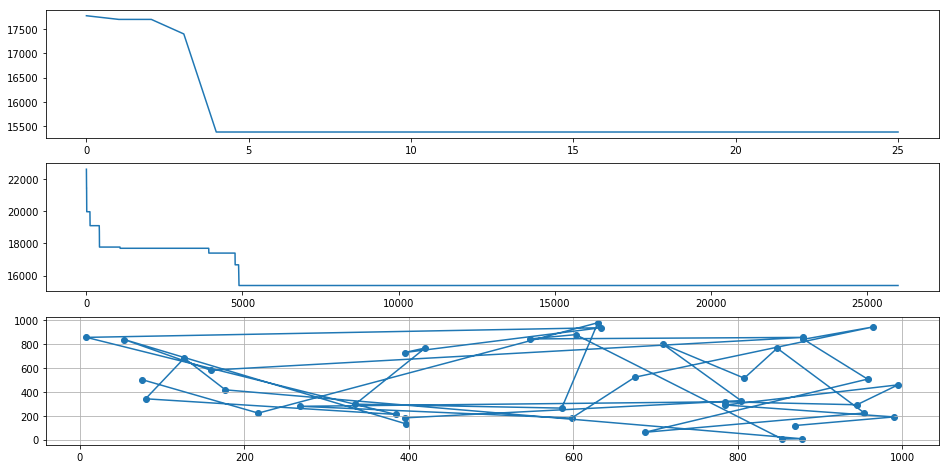

The shortest distance is:14839.334285 The best solution is [1, 29, 4, 32, 17, 15, 20, 27, 23, 22, 24, 0, 11, 16, 14, 9, 21, 8, 12, 3, 34, 26, 2, 35, 38, 7, 33, 28, 30, 13, 10, 6, 19, 31, 36, 5, 37, 18, 25, 39]


In [45]:
import time
start = time.time()
init_cities, distance_mat = init_(40)
res, distance_all = simulated_annealing_tsp(40, init_cities, distance_mat)
end = time.time()
print("TSP run time is", end-start)
plot_path(res, init_cities, distance_all)

minimum, final_result = repeat_TSP(5, 40, init_cities, distance_mat)
print('The shortest distance is:%f' % minimum, "The best solution is",final_result)

TSP run time is 5.289810419082642


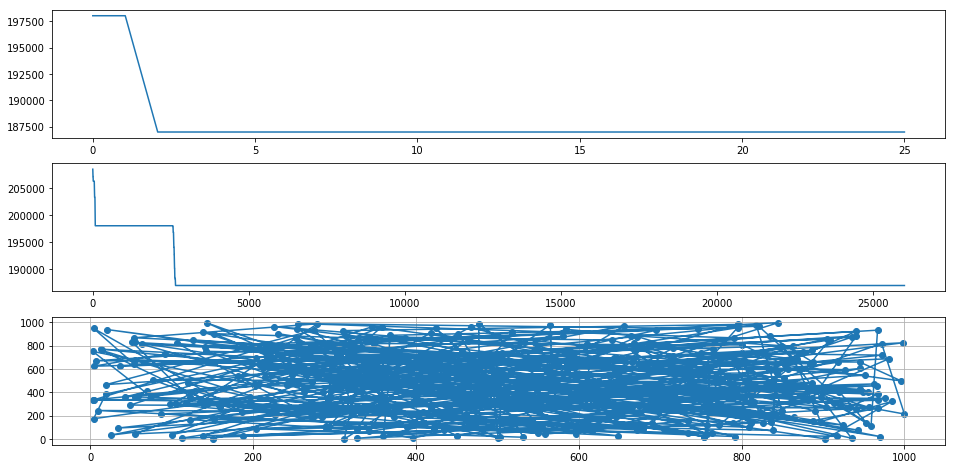

The shortest distance is:12638.192675 The best solution is [22, 11, 14, 6, 2, 30, 32, 5, 26, 10, 4, 36, 35, 16, 12, 21, 20, 31, 27, 18, 25, 34, 8, 1, 24, 33, 39, 7, 29, 37, 3, 17, 15, 28, 38, 13, 19, 9, 23, 0]


In [46]:
import time
start = time.time()
init_cities, distance_mat = init_(400)
res, distance_all = simulated_annealing_tsp(400, init_cities, distance_mat)
end = time.time()
print("TSP run time is", end-start)
plot_path(res, init_cities, distance_all)

minimum, final_result = repeat_TSP(5, 40, init_cities, distance_mat)
print('The shortest distance is:%f' % minimum, "The best solution is",final_result)

TSP run time is 5.404755353927612


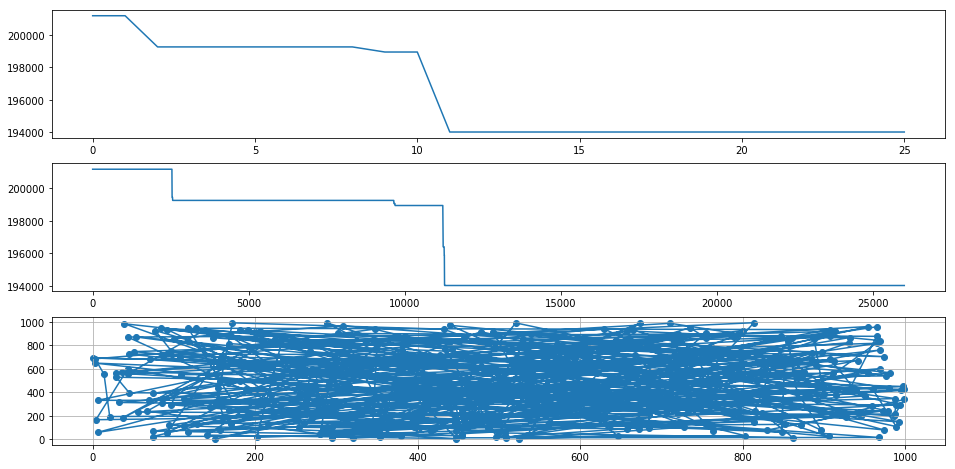

The shortest distance is:195052.929222 The best solution is [44, 359, 187, 216, 374, 163, 164, 43, 155, 83, 169, 122, 213, 263, 327, 184, 332, 289, 127, 95, 68, 194, 18, 307, 382, 132, 138, 230, 256, 260, 59, 367, 264, 295, 210, 284, 186, 379, 309, 203, 48, 265, 360, 87, 72, 42, 204, 365, 251, 291, 125, 253, 25, 98, 115, 277, 308, 394, 17, 323, 372, 107, 196, 239, 274, 321, 350, 49, 254, 104, 121, 296, 288, 141, 202, 154, 364, 20, 190, 368, 137, 91, 285, 179, 250, 67, 74, 126, 69, 388, 258, 352, 325, 167, 343, 294, 221, 97, 215, 85, 342, 119, 189, 33, 171, 200, 370, 267, 133, 389, 166, 341, 375, 273, 317, 188, 262, 30, 21, 300, 71, 301, 157, 182, 217, 207, 384, 9, 23, 224, 211, 4, 136, 227, 118, 108, 212, 6, 278, 162, 50, 240, 236, 124, 61, 101, 51, 65, 272, 326, 86, 271, 304, 161, 269, 13, 0, 172, 147, 128, 109, 320, 270, 57, 90, 371, 223, 348, 297, 168, 356, 60, 191, 209, 383, 131, 78, 12, 130, 77, 81, 259, 100, 34, 355, 40, 242, 76, 177, 149, 302, 123, 245, 73, 7, 234, 322, 199, 175

In [47]:
import time
start = time.time()
init_cities, distance_mat = init_(400)
res, distance_all = simulated_annealing_tsp(400, init_cities, distance_mat)
end = time.time()
print("TSP run time is", end-start)
plot_path(res, init_cities, distance_all)

minimum, final_result = repeat_TSP(5, 400, init_cities, distance_mat)
print('The shortest distance is:%f' % minimum, "The best solution is",final_result)

ii. Run the Simulated Annealing TSP solver you just developed for N = {40, 400, 1000} cities. Explore the speed and convergence properties at these different problem sizes. You might want to play with the cooling schedules.

As N increases, the run time increases, but when N reach threshold, run time will reach convergence. Since when N reaches threshold, the iteration of the procedure will be determined because of cooling schdule, that is, the number of iteration will be determined. Of course the speed will convergence.